# GLM group maps and tables

In [49]:
# Imports
import os
from nilearn.glm import threshold_stats_img
from nilearn import plotting
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.reporting import get_clusters_table
from nilearn.image import math_img
from mni_to_atlas import AtlasBrowser

atlas = AtlasBrowser("AAL3")

# set pandas to display 100 rows
pd.set_option("display.max_rows", 100)

In [3]:
# Settings
# data_dir = '/SCRATCH/users/alexandresayal/BIDS-BRAINPLAYBACK-TASK2/'
data_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/"
# data_dir = "/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK2"  # sim01 dir

fmriprep_dir = os.path.join(data_dir, "derivatives", "fmriprep23")  # fmriprep output

out_dir = os.path.join(data_dir, "derivatives", "nilearn_glm")
out_dir_group = os.path.join(data_dir, "derivatives", "nilearn_glm", "group")
group_fig_dir = os.path.join(data_dir, "derivatives", "nilearn_glm", "group_figures")
group_tab_dir = os.path.join(data_dir, "derivatives", "nilearn_glm", "group_tables")
group_clust_dir = os.path.join(data_dir, "derivatives", "nilearn_glm", "group_clusters")

# Create output directories if they do not exist
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(out_dir_group):
    os.makedirs(out_dir_group)
if not os.path.exists(group_fig_dir):
    os.makedirs(group_fig_dir)
if not os.path.exists(group_tab_dir):
    os.makedirs(group_tab_dir)
if not os.path.exists(group_clust_dir):
    os.makedirs(group_clust_dir)

In [4]:
from templateflow import api as tflow

# T1w image
t1w_img = tflow.get("MNI152NLin2009cAsym", desc="brain", resolution=1, suffix="T1w", extension="nii.gz")

In [75]:
contrasts_renamed = [
    "All",
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
    "Sublimity",
    "Vitality",
    "Unease",
    "SublimityMinusVitality",
    "VitalityMinusUnease",
    "UneaseMinusSublimity",
]

emotion_names = [
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
]

subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

n_subjects = len(subject_list)
n_emotions = len(emotion_names)

# Sum of contrasts

In [35]:
# Threshold values
hc = "fdr"  # None, 'bonferroni', 'fdr'
ct = 20  # cluster threshold
alpha = 0.05  # p-value threshold

# Let's get the maps for each emotion (emotion_names), threshold them, and sum them

z_map_list = []
for emotion in emotion_names:
    z_map_list.append(os.path.join(out_dir_group, f"group_task-02a_stat-z_con-{emotion}.nii.gz"))

# Let's threshold the z-maps
thresholded_maps = []
min_thres = 99
for z_map in z_map_list:
    thresholded_img, aux_thres = threshold_stats_img(
        z_map,
        alpha=alpha,
        height_control=hc,
        cluster_threshold=ct,
        two_sided=False,
    )
    thresholded_maps.append(thresholded_img)
    if aux_thres < min_thres:
        min_thres = aux_thres

# Let's sum the thresholded maps
sum_img = thresholded_maps[0]
for img in thresholded_maps[1:]:
    sum_img = math_img("img1 + img2", img1=sum_img, img2=img)

# and divide by the number of emotions
sum_img = math_img("img1 / 9", img1=sum_img)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



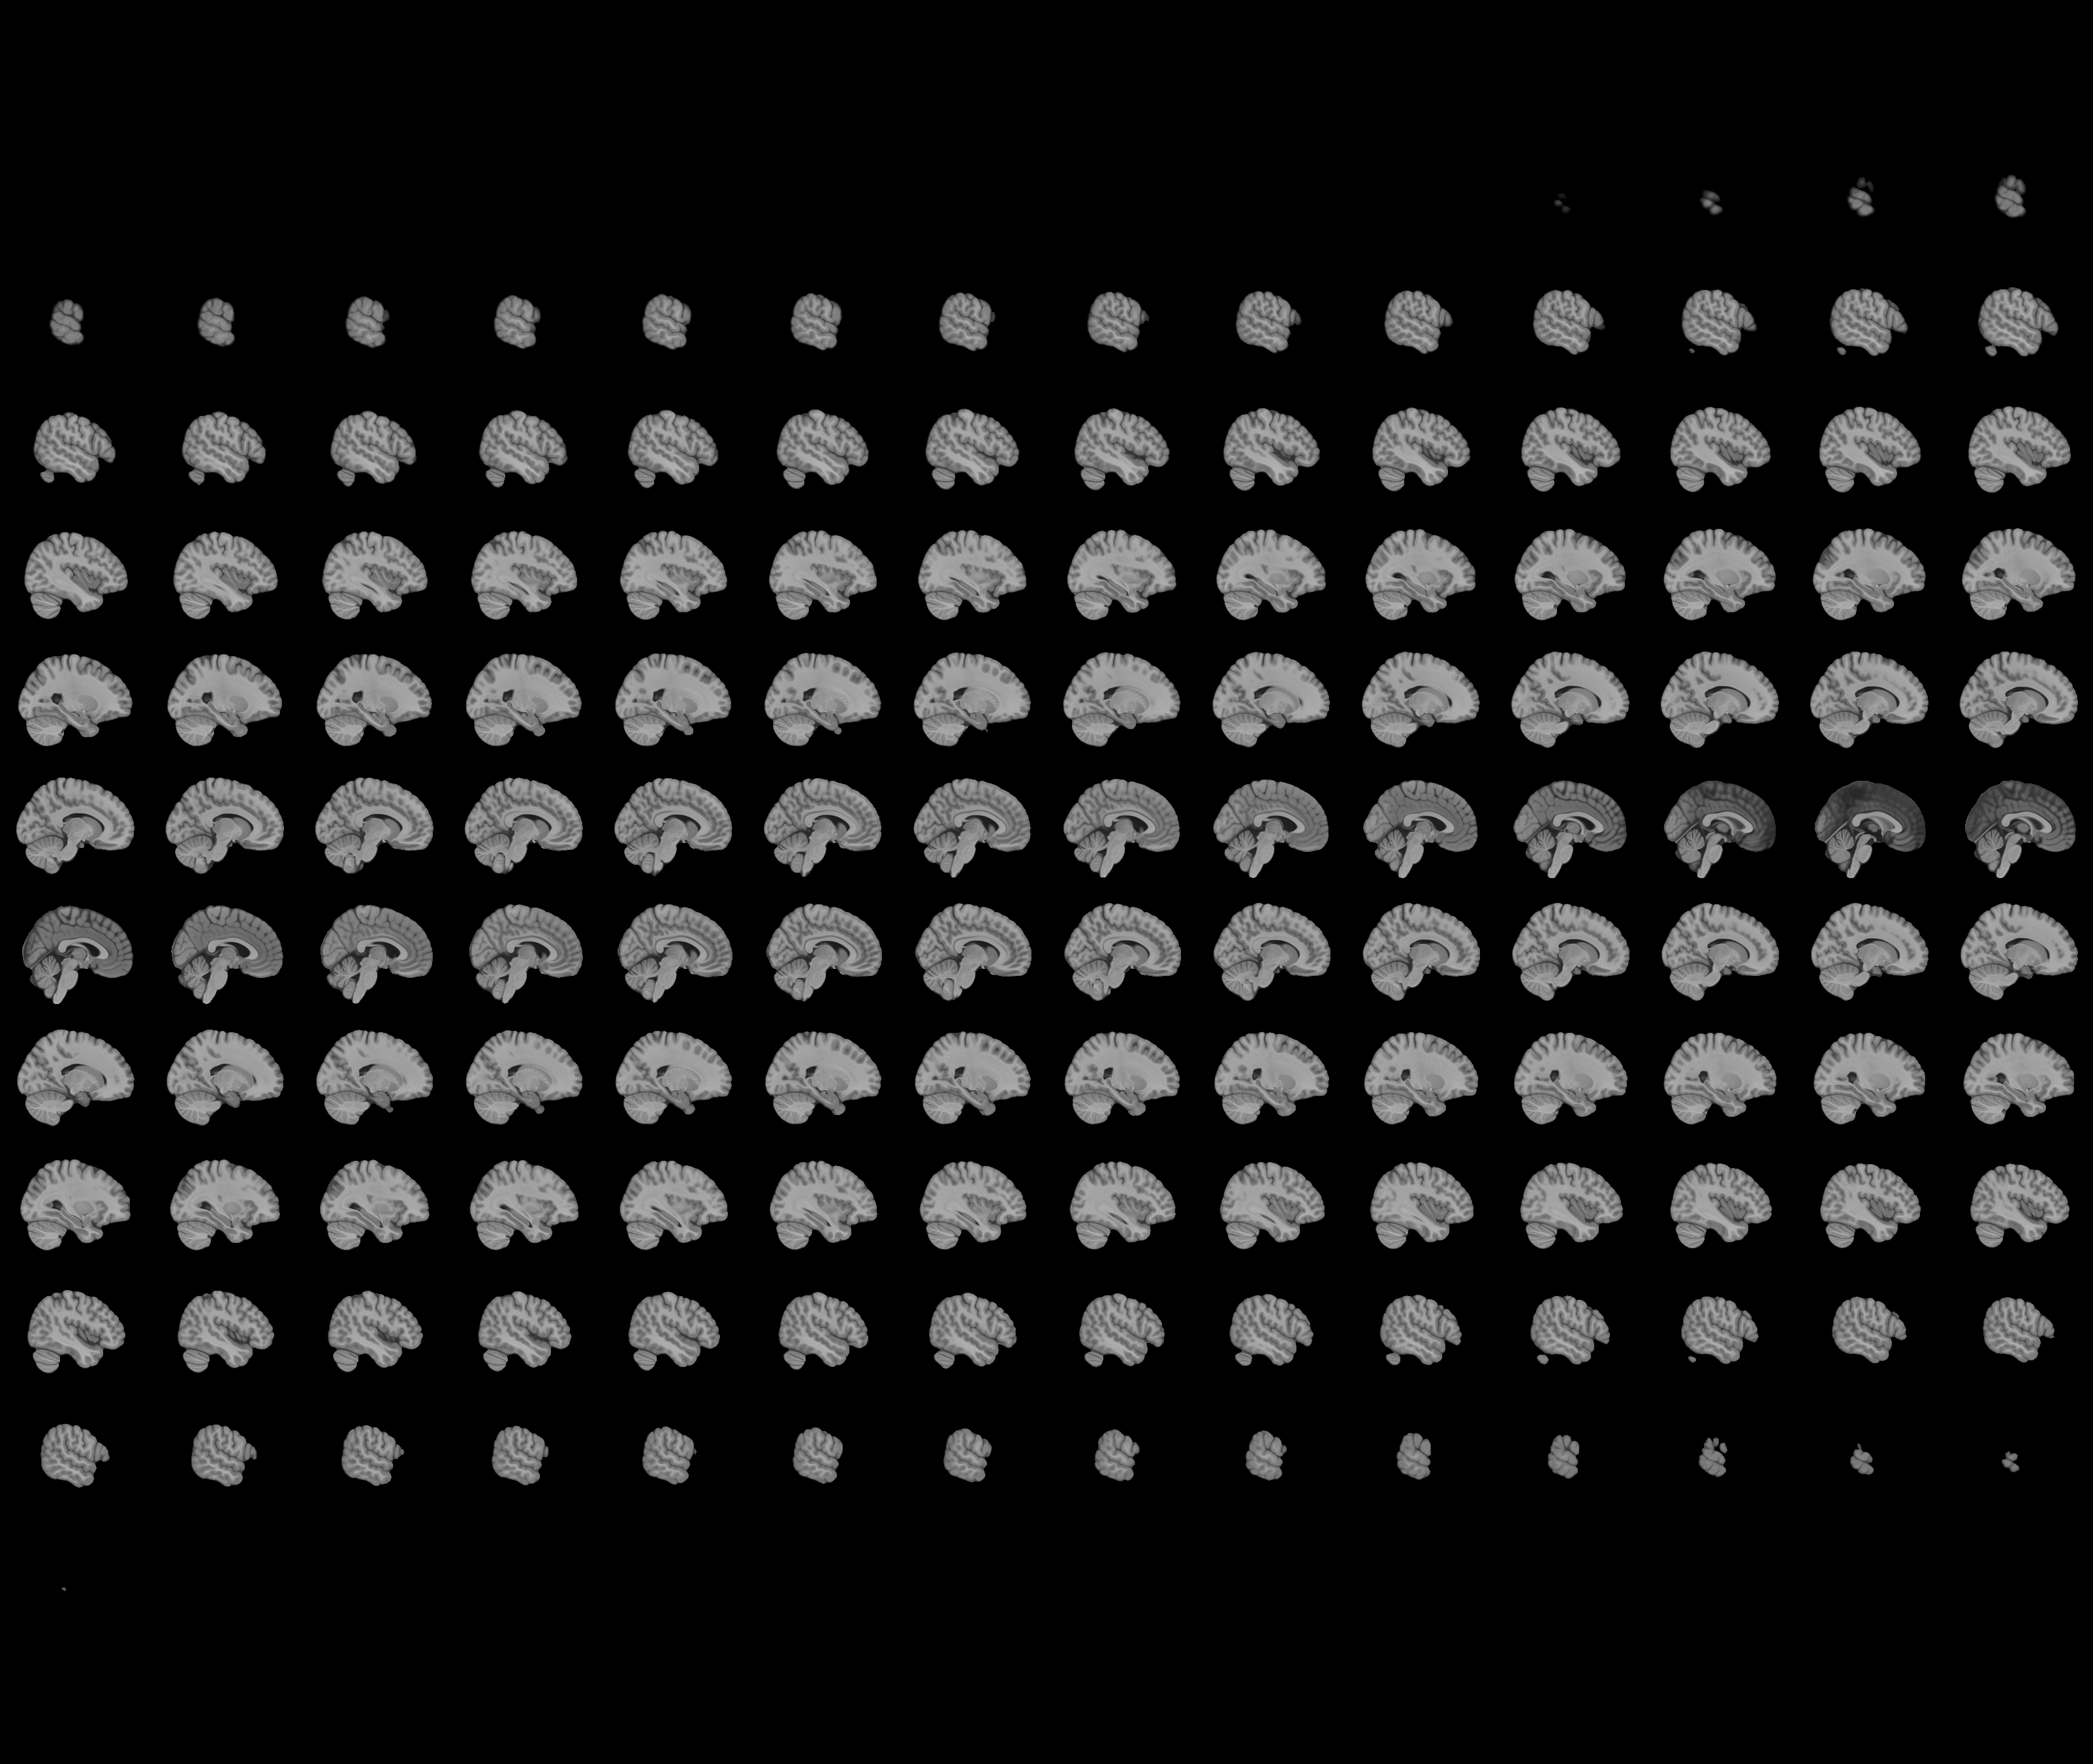

In [37]:
# Let's plot with view_img
plotting.view_img(sum_img, bg_img=t1w_img)

In [ ]:
# Cluster table
table_sum, cluster_map_sum = get_clusters_table(sum_img, 0, 1, two_sided=False, return_label_maps=True)

# AAL3 labelling
coordinates = table_sum[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_sum["AAL3"] = aal_labels

table_sum

Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)  \
0           1  53.5   1.5  -4.5   6.433643              22864   
1          1a  53.5 -10.5   3.5   6.258794                      
2          1b  59.5   1.5  -0.5   5.735311                      
3          1c  63.5 -16.5   9.5   5.540591                      
4           2 -52.5 -14.5   5.5   6.154709              24456   
5          2a -56.5  -4.5  -0.5   6.152053                      
6          2b -54.5 -20.5   7.5   6.083356                      
7          2c -48.5  -0.5  -6.5   5.357593                      
8           3  29.5 -60.5 -24.5   5.050490              12848   
9          3a  11.5 -68.5 -14.5   3.750252                      
10         3b   9.5 -76.5 -18.5   3.511545                      
11         3c   9.5 -84.5 -30.5   2.776934                      
12          4 -32.5 -62.5 -22.5   4.728441               5848   
13         4a -10.5 -66.5 -12.5   2.044841                      
14         4b -10.5 -58.5 -10.5   1.283742                      
15         4c -46.5 -64.5 -26.5   1.246495                      
16          5  55.5  -2.5  45.5   4.335616               2240   
17          6  -0.5   1.5  67.5   4.207597               4592   
18         6a  -4.5  -6.5  69.5   3.148708                      
19         6b   5.5  -2.5  75.5   2.590469                      
20          7 -54.5  -6.5  47.5   3.808528               2040   
21         7a -46.5  -6.5  59.5   0.367741                      
22          8 -24.5 -64.5 -52.5   3.321164               1856   
23         8a -30.5 -60.5 -56.5   2.185823                      
24         8b -34.5 -48.5 -50.5   0.414932                      
25          9  23.5   3.5   5.5   2.194209                944   
26         9a  25.5  -2.5  11.5   0.434126                      
27         10  17.5 -68.5 -52.5   2.056227               4648   
28        10a  41.5 -76.5 -38.5   1.563357                      
29        10b  31.5 -60.5 -56.5   1.496467                      
30        10c  31.5 -70.5 -44.5   1.473979                      
31         11 -14.5 -78.5 -44.5   1.927174               1096   
32         12  55.5  35.5   3.5   1.872756                880   
33         13 -46.5  47.5  -4.5   1.170215               3512   
34        13a -48.5  35.5   9.5   0.758565                      
35        13b -48.5  21.5  25.5   0.691777                      
36        13c -42.5  27.5  27.5   0.446457                      
37         14 -38.5  45.5 -16.5   1.028852                528   
38         15 -16.5 -26.5  -6.5   0.898069                344   
39         16 -22.5  37.5  49.5   0.846158                528   
40        16a -20.5  33.5  57.5   0.697743                      
41         17  -4.5  61.5  25.5   0.845779                528   
42        17a  -2.5  55.5  33.5   0.495069                      
43         18 -24.5   1.5   7.5   0.818033                600   
44        18a -22.5   1.5  -2.5   0.423613                      
45        18b -22.5  -4.5  11.5   0.386149                      
46         19  -2.5  29.5  43.5   0.668127                552   
47        19a  -4.5  21.5  51.5   0.461415                      
48        19b  -8.5  27.5  41.5   0.360302                      
49         20   1.5 -32.5 -12.5   0.505155                184   
50        20a  -6.5 -30.5 -12.5   0.428302                      
51         21 -40.5  31.5  -0.5   0.503647                416   
52         22  -8.5 -38.5 -30.5   0.496611                248   
53        22a  -0.5 -44.5 -20.5   0.367087                      
54         23  -4.5  37.5 -18.5   0.493980               1112   
55        23a  -4.5  57.5  -8.5   0.485628                      
56        23b  -6.5  47.5 -14.5   0.469483                      
57        23c  -0.5  45.5 -20.5   0.457105                      
58         24 -24.5  31.5 -14.5   0.479667                224   
59         25 -42.5  23.5  19.5   0.448285                192   
60         26  23.5 -38.5 -42.5   0.42

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:805: UserWarning: Casting data from int32 to float32
  return resample_img(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



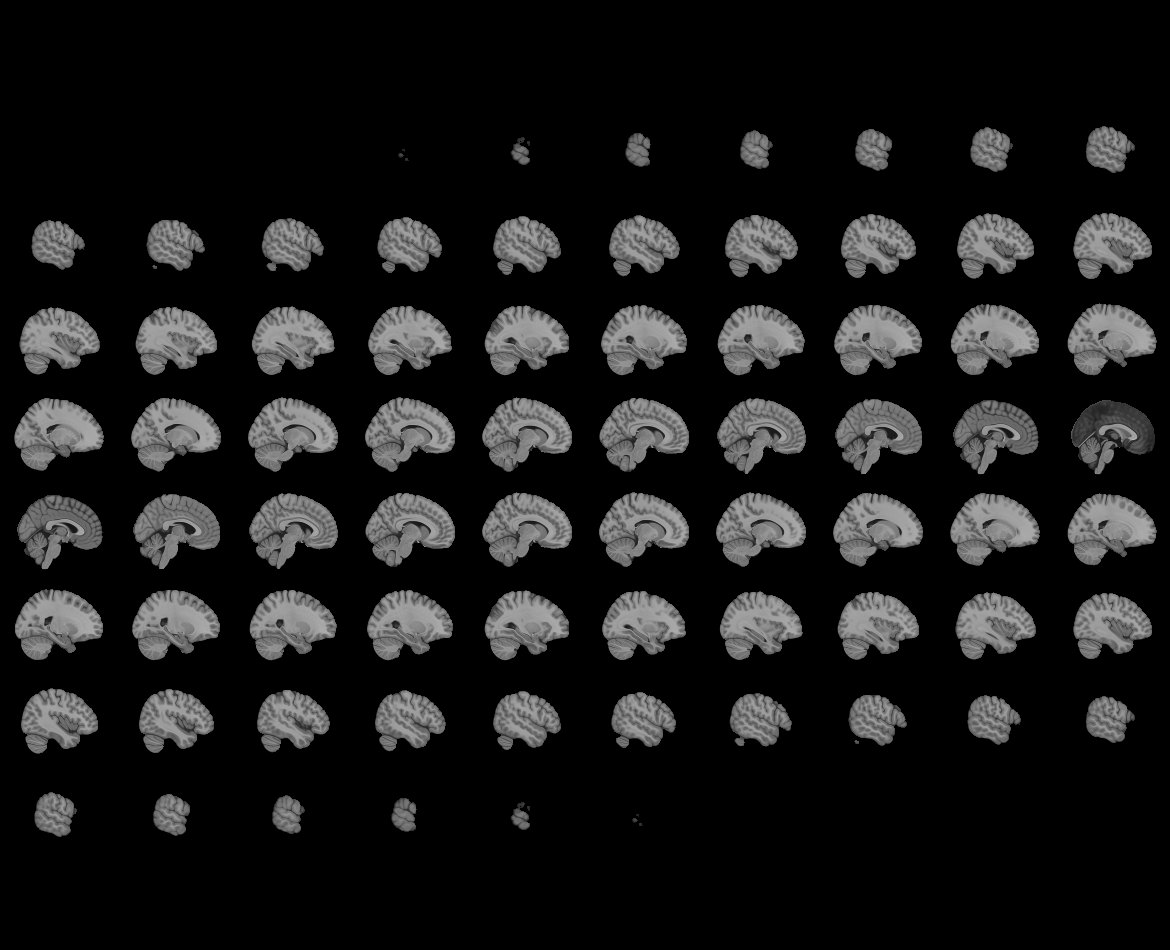
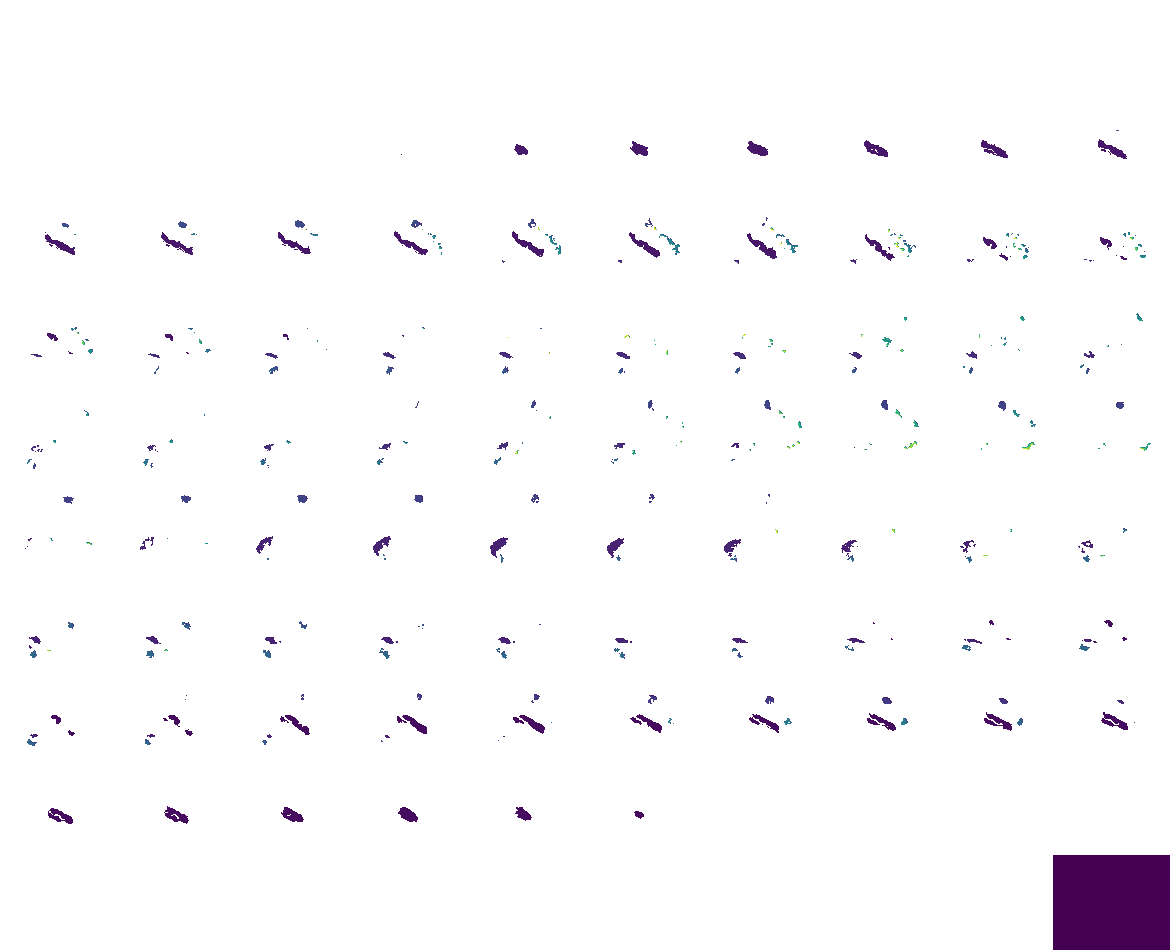

In [47]:
plotting.view_img(cluster_map_sum[0], threshold=0, symmetric_cmap=False, cmap="viridis")

In [52]:
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(cluster_map_sum[0])
masker.fit()

masker.generate_report()

/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_52949/1108349811.py:6: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  masker.generate_report()
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(


In [85]:
# Using this masker, let's get the z-scores for each emotion for all clusters
z_scores_clusters = np.full((n_subjects, n_emotions, 30), np.nan)  # Initialize a 20x9x30 array filled with NaN

for ss, sub in enumerate(subject_list):
    print(f"Processing subject {sub}")
    for ee, emotion in enumerate(emotion_names):
        z_map = os.path.join(out_dir, f"sub-{sub}_task-02a_stat-z_con-{emotion}.nii.gz")

        # apply light thresholding to z_map
        z_map_thres, _ = threshold_stats_img(
            z_map,
            alpha=0.05,
            height_control=None,
            cluster_threshold=5,
            two_sided=False,
        )

        # create mask for thresholded z_map
        z_map_thres_mask = math_img("img1 > 0", img1=z_map_thres)

        # create LabelsMasker considering this mask
        masker = NiftiLabelsMasker(cluster_map_sum[0], mask_img=z_map_thres_mask)

        # apply mask to z_map
        z_map_masked = masker.fit_transform(z_map_thres)
        z_scores_clusters[ss, ee, :] = z_map_masked


Processing subject 01


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


Processing subject 02
Processing subject 03
Processing subject 04
Processing subject 05
Processing subject 06
Processing subject 07
Processing subject 08
Processing subject 09
Processing subject 10
Processing subject 11
Processing subject 12
Processing subject 13
Processing subject 14
Processing subject 15
Processing subject 16
Processing subject 17
Processing subject 18
Processing subject 19
Processing subject 20


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_52949/171591837.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


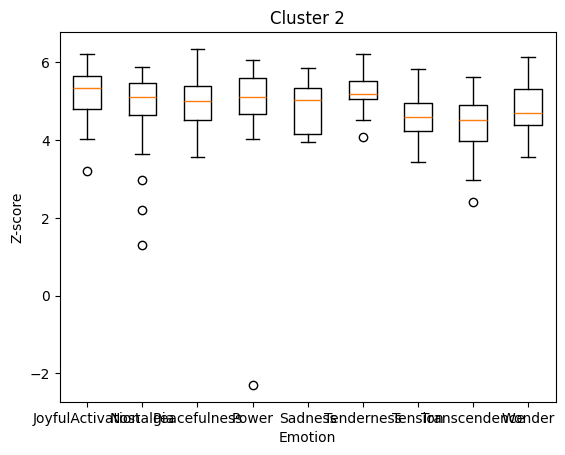

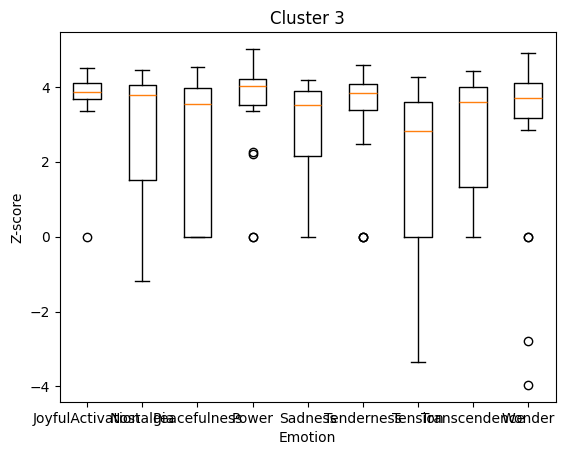

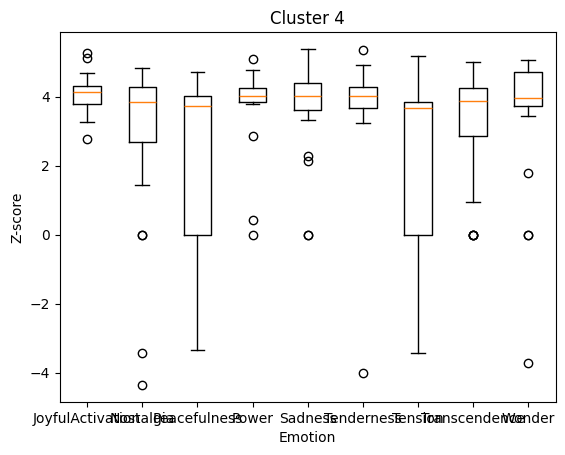

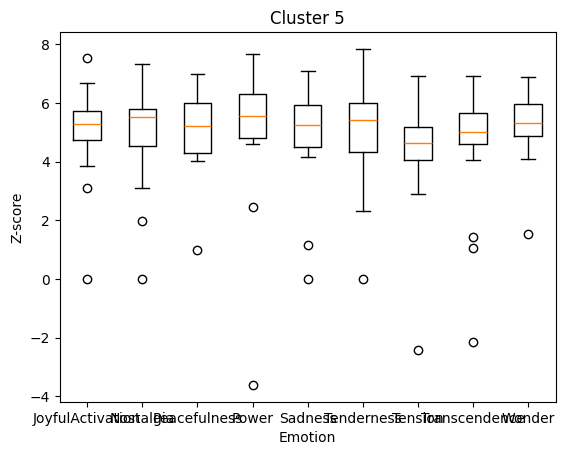

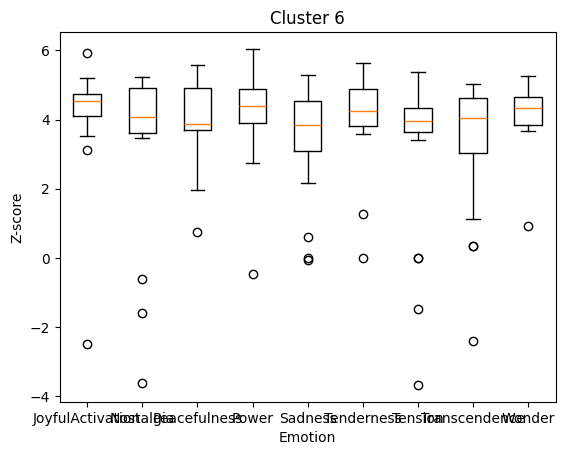

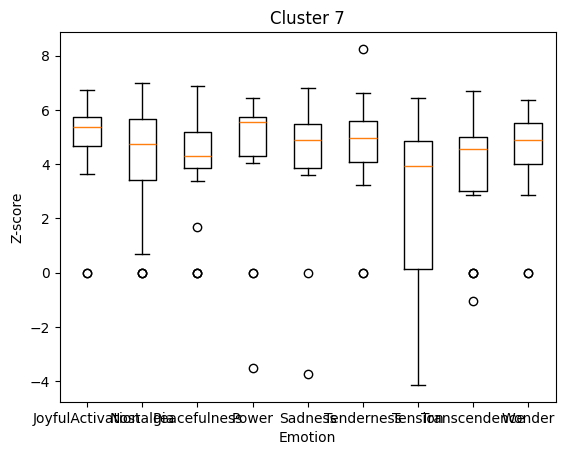

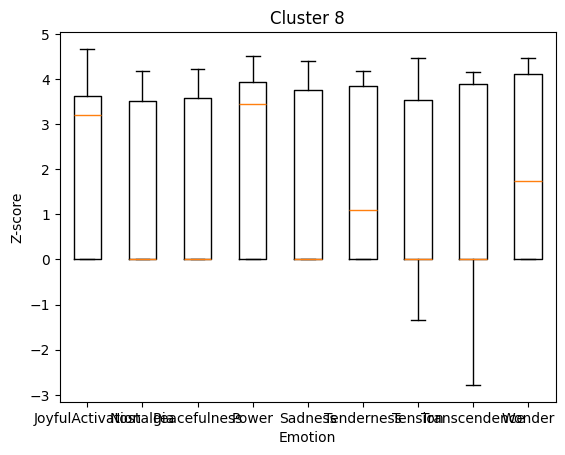

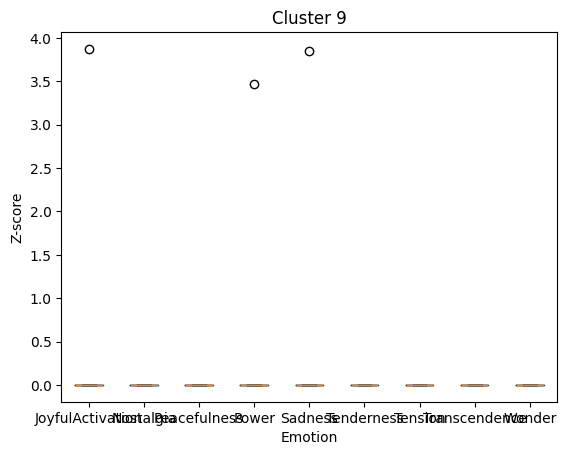

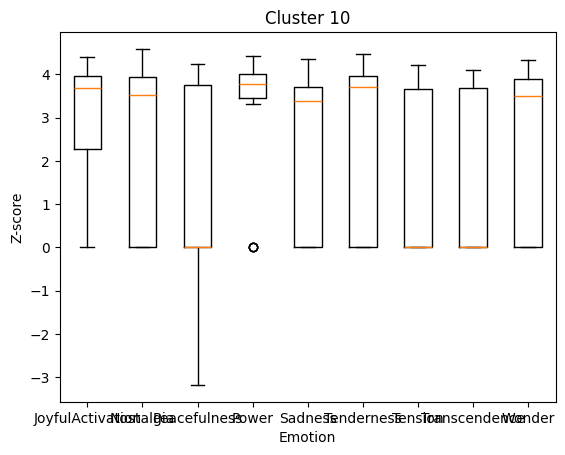

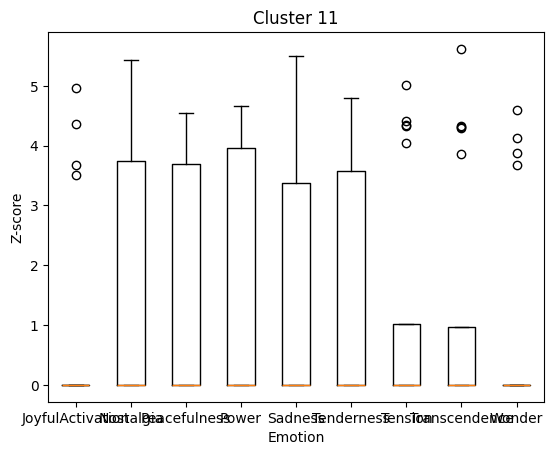

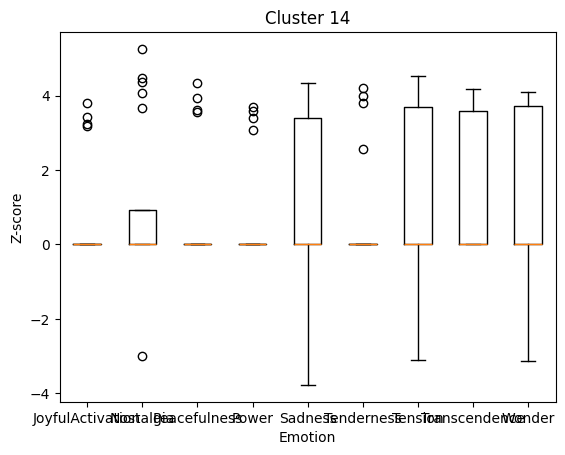

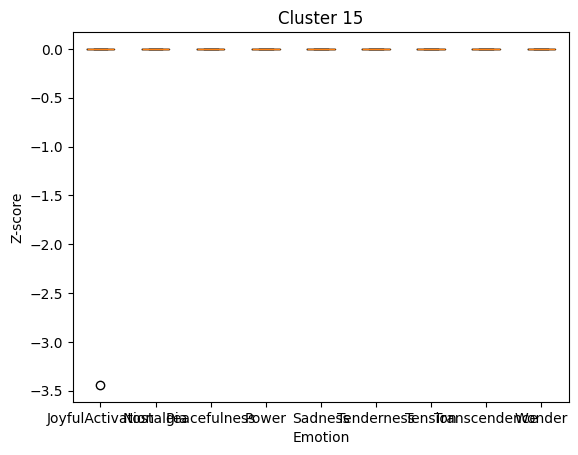

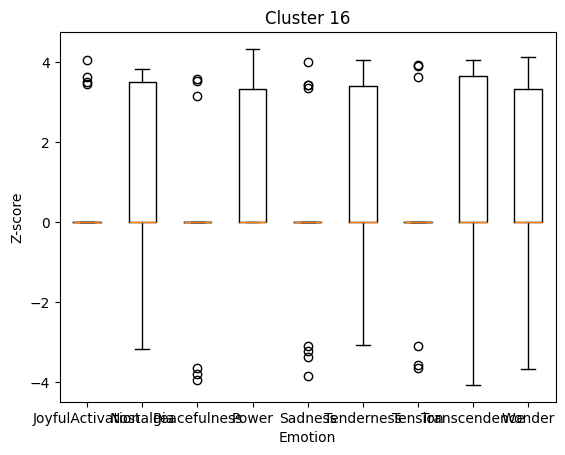

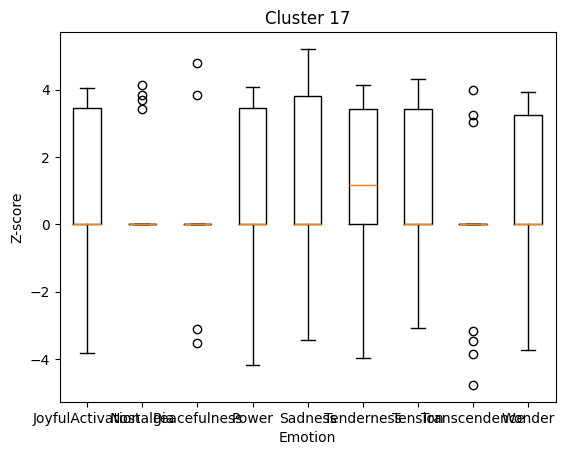

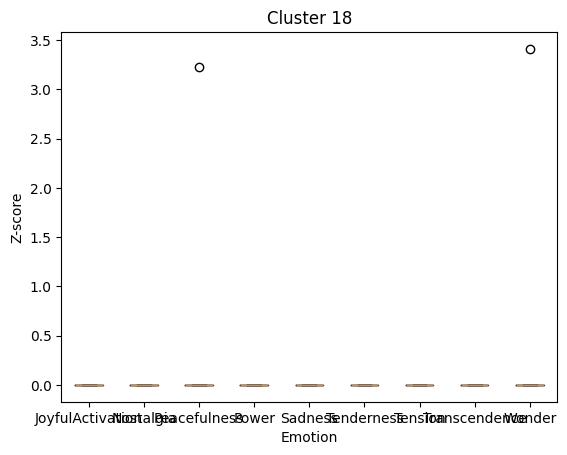

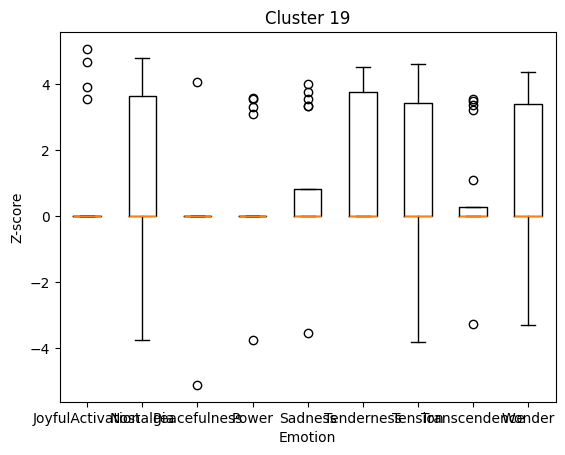

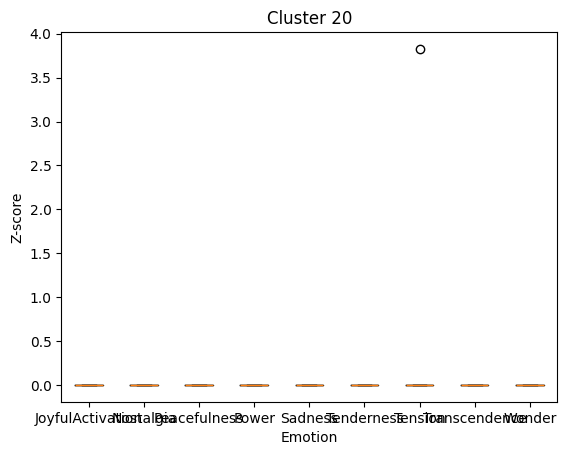

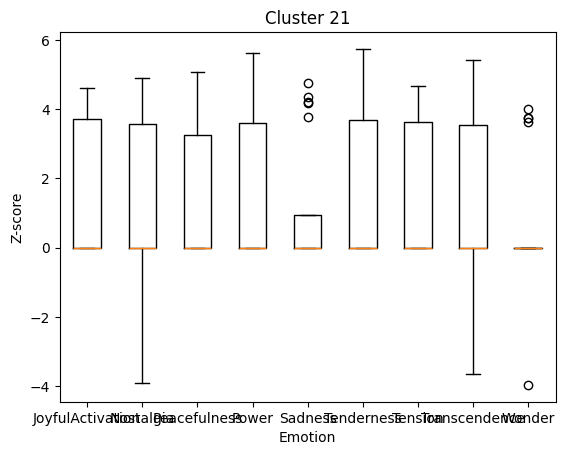

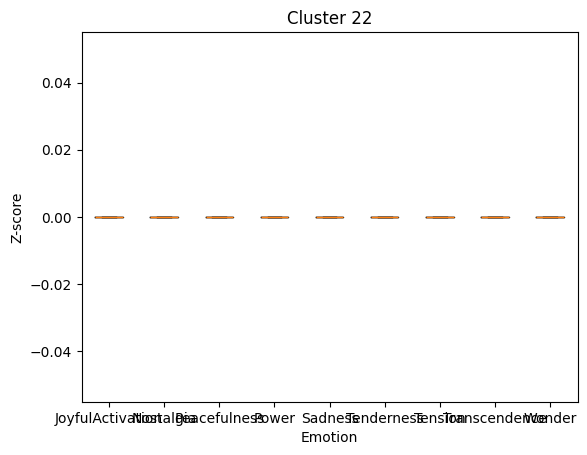

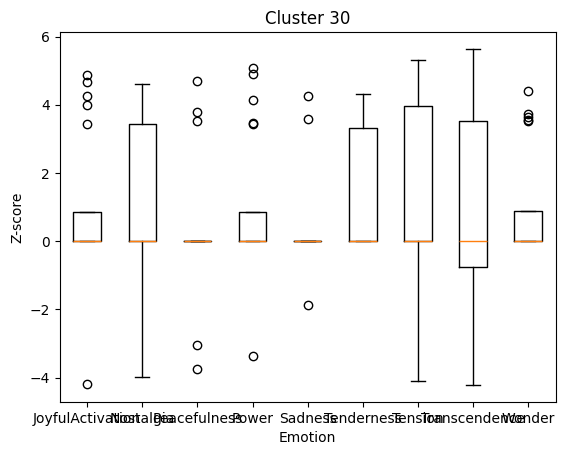

In [84]:
# boxplot all clusters - x-axis is emotion, y is z-score
for i in range(30):
    plt.figure()
    plt.boxplot(z_scores_clusters[:, :, i], tick_labels=emotion_names)
    plt.title(f"Cluster {i + 1}")
    plt.xlabel("Emotion")
    plt.ylabel("Z-score")


# 2nd level ALL

In [32]:
# Threshold values
hc = "fdr"  # None, 'bonferroni', 'fdr'
ct = 20  # cluster threshold
alpha = 0.01  # p-value threshold

In [33]:
c_idx = 0
print(contrasts_renamed[c_idx])

All


Threshold: 3.3123059318688766


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



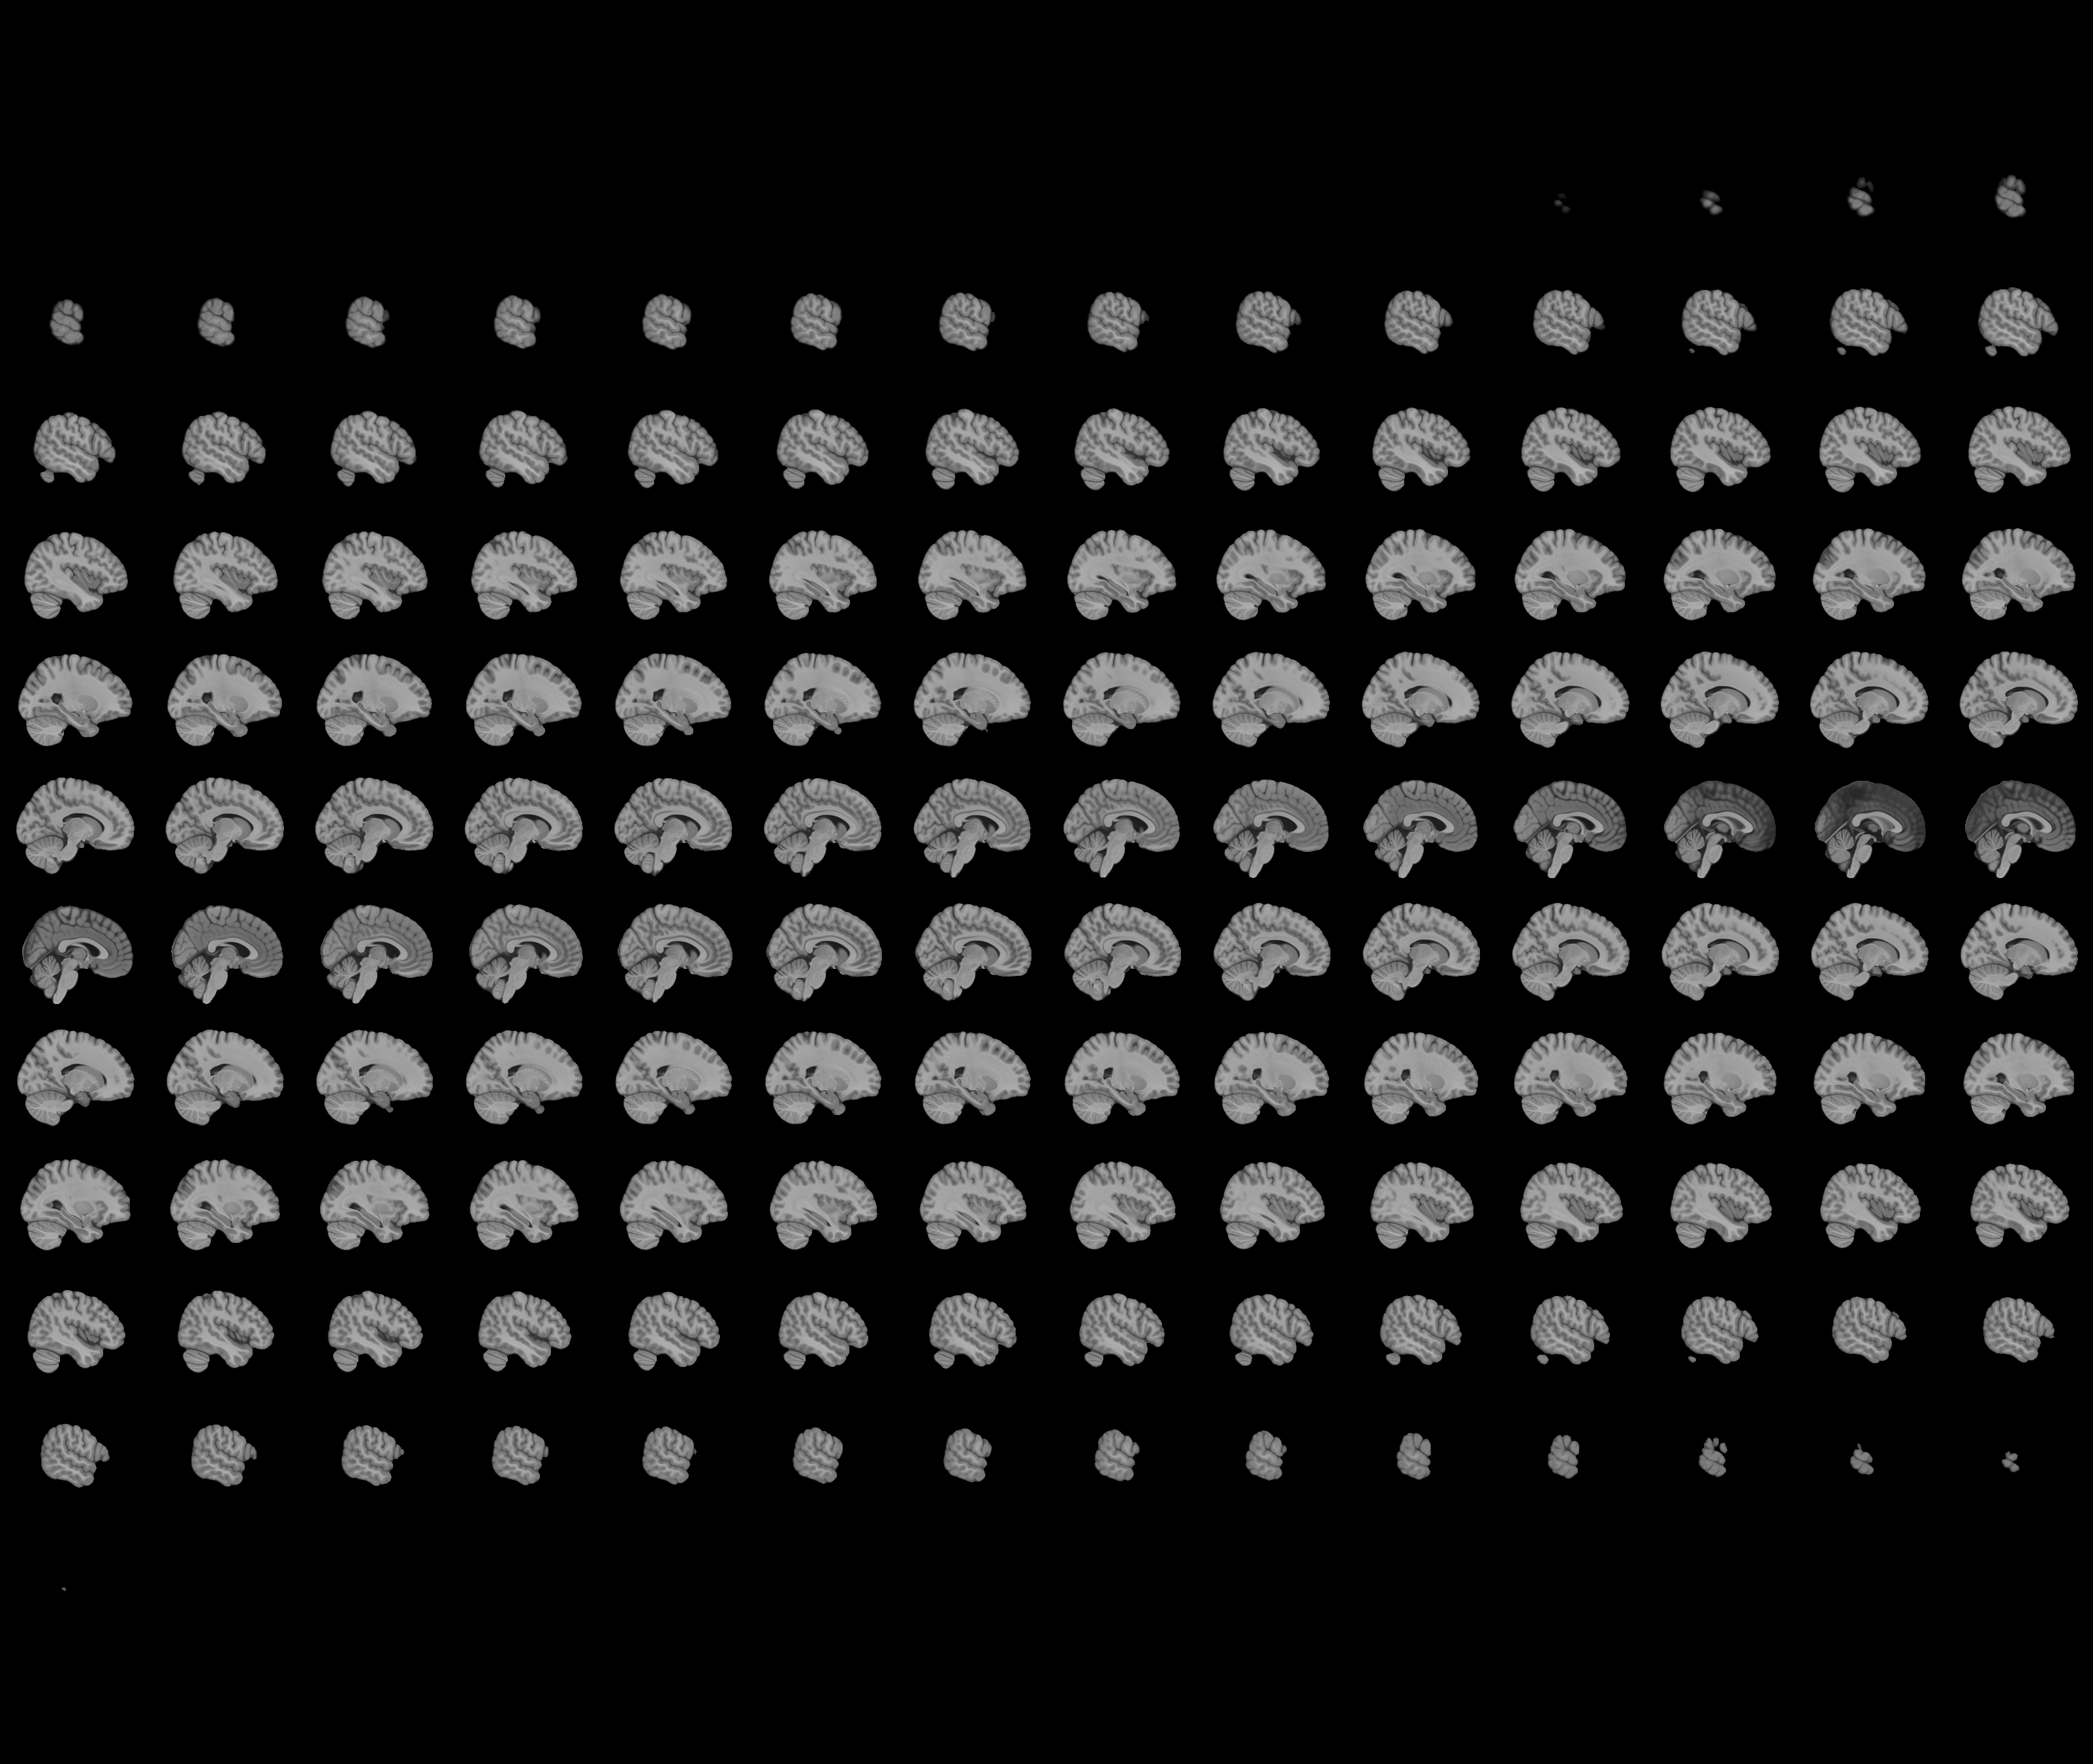

In [34]:
z_map_g = os.path.join(out_dir_group, f"group_task-02a_stat-z_con-{contrasts_renamed[c_idx]}.nii.gz")

clean_map_g, threshold_g = threshold_stats_img(z_map_g, alpha=alpha, height_control=hc, cluster_threshold=ct)

print(f"Threshold: {threshold_g}")

# threshold clean_map_g to only show positive values
clean_map_g = math_img("np.maximum(img, 0)", img=clean_map_g)

# View map interactively
plotting.view_img(
    clean_map_g,
    threshold=threshold_g,
    symmetric_cmap=False,
    colorbar=True,
    cmap="hot",
    cut_coords=(21, -2, -16),
    width_view=800,
    bg_img=t1w_img,
    resampling_interpolation="nearest",
)

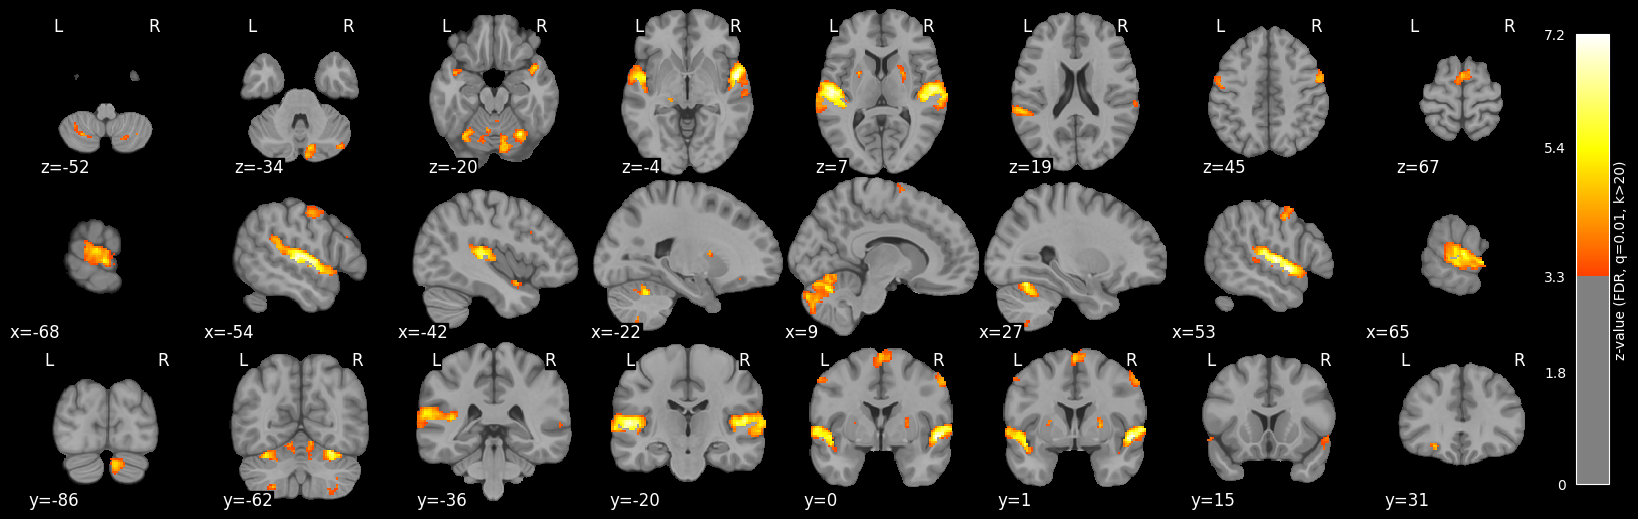

In [15]:
# beautiful mosaic figure

# Create a new figure and axis with black background
fig = plt.figure(figsize=(16, 5), facecolor="black")

display = plotting.plot_stat_map(
    clean_map_g,
    threshold=threshold_g,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    symmetric_cbar=False,
    cmap="hot",
    figure=fig,
    bg_img=t1w_img,
    resampling_interpolation="nearest",
)

# Customize the colorbar
cbar = display._cbar
cbar.set_label(f"z-value (FDR, q={alpha}, k>{ct})")
# change colorbar label color to white
cbar.ax.yaxis.label.set_color("white")

# Show the plot
plt.show()

In [16]:
# Save the thresholded map figure
fig_file = os.path.join(
    group_fig_dir,
    f"mosaic_stat-z_con-{contrasts_renamed[c_idx]}_{hc}-{alpha}_k-{ct}.png",
)
plt.savefig(fig_file, bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_figures/mosaic_stat-z_con-All_fdr-0.01_k-20.png'

<Figure size 640x480 with 0 Axes>

In [14]:
# Cluster table
table_g, cluster_map_g = get_clusters_table(z_map_g, threshold_g, ct, return_label_maps=True)

# AAL3 labelling
coordinates = table_g[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table_g["AAL3"] = aal_labels

# print(table_g)
# print(table.to_latex())
table_g

Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)  \
0           1 -56.5  -4.5  -0.5   6.944128              14792   
1          1a -54.5 -12.5   5.5   6.611807                      
2          1b -54.5 -20.5   7.5   5.941758                      
3          1c -48.5  -0.5  -4.5   5.595680                      
4           2  53.5 -12.5   5.5   6.738948              14912   
5          2a  53.5  -2.5  -2.5   6.604953                      
6          2b  63.5 -16.5   9.5   5.796945                      
7          2c  47.5 -14.5   3.5   5.779770                      
8           3  29.5 -62.5 -24.5   5.963387               1632   
9          3a  19.5 -58.5 -26.5   4.081020                      
10         3b  25.5 -70.5 -20.5   3.920123                      
11         3c  31.5 -50.5 -24.5   3.900437                      
12          4 -30.5 -62.5 -24.5   4.966772               1456   
13         4a -22.5 -58.5 -24.5   4.439204                      
14          5  -0.5   1.5  67.5   4.946857               1464   
15         5a   9.5   1.5  71.5   3.878769                      
16          6 -14.5 -68.5 -16.5   4.832771                512   
17         6a -10.5 -58.5 -12.5   3.806020                      
18          7  11.5 -72.5 -18.5   4.613710               1352   
19         7a   3.5 -66.5 -10.5   4.571843                      
20         7b  15.5 -70.5 -18.5   4.439442                      
21         7c   7.5 -66.5 -18.5   4.241374                      
22          8  55.5  -0.5  47.5   4.532243               1184   
23          9  -2.5  55.5  33.5   4.455623                288   
24         9a  -6.5  61.5  23.5   3.920028                      
25         10  -4.5  37.5 -18.5   4.445817                872   
26        10a  -4.5  57.5  -8.5   4.370655                      
27        10b  -6.5  47.5 -14.5   4.225343                      
28        10c  -0.5  45.5 -20.5   4.113942                      
29         11 -20.5  39.5  47.5   4.375808                352   
30         12  39.5 -72.5 -36.5   4.238532                288   
31         13 -24.5 -64.5 -52.5   4.044017                248   
32        13a -30.5 -60.5 -56.5   3.477694                      
33         14 -56.5  -6.5  47.5   3.989886                640   

                    AAL3  
0         Temporal_Sup_L  
1         Temporal_Sup_L  
2         Temporal_Sup_L  
3         Temporal_Sup_L  
4               Heschl_R  
5         Temporal_Sup_R  
6         Temporal_Sup_R  
7               Heschl_R  
8         Cerebellum_6_R  
9         Cerebellum_6_R  
10        Cerebellum_6_R  
11        Cerebellum_6_R  
12        Cerebellum_6_L  
13        Cerebellum_6_L  
14     Supp_Motor_Area_L  
15     Supp_Motor_Area_R  
16        Cerebellum_6_L  
17      Cerebellum_4_5_L  
18        Cerebellum_6_R  
19              Vermis_6  
20        Cerebellum_6_R  
21        Cerebellum_6_R  
22          Precentral_R  
23  Frontal_Sup_Medial_L  
24  Frontal_Sup_Medial_L  
25              Rectus_L  
26     Frontal_Med_Orb_L  
27     Frontal_Med_Orb_L  
28              Rectus_L  
29       Frontal_Sup_2_L  
30    Cerebellum_Crus1_R  
31        Cerebellum_8_L  
32        Cerebellum_8_L  
33         Postcentral_L

In [20]:
# Export cluster table
table_g.to_csv(
    os.path.join(
        group_tab_dir,
        f"clusters_con-{contrasts_renamed[c_idx]}_{hc}-{alpha}_k-{ct}.tsv",
    ),
    sep="\t",
)

In [21]:
# save cluster_map_g
cluster_map_g[0].to_filename(
    os.path.join(
        group_clust_dir,
        f"clustersmap_con-{contrasts_renamed[c_idx]}_{hc}-{alpha}_k-{ct}.nii.gz",
    ),
)

In [22]:
# split map into separate files
import nibabel as nib

# Load the cluster map
cluster_data = cluster_map_g[0].get_fdata()

# Filter table_g to include only integer Cluster IDs
integer_cluster_ids = [cluster_id for cluster_id in table_g["Cluster ID"] if isinstance(cluster_id, int)]

# Iterate through each cluster in the table and create masks
for cluster_id in integer_cluster_ids:
    # Create a binary mask for the current cluster
    cluster_mask_data = (cluster_data == cluster_id).astype(int)

    # Create a new Nifti image for the mask
    cluster_mask_img = nib.Nifti1Image(cluster_mask_data, cluster_map_g[0].affine, cluster_map_g[0].header)

    # Define the output file path
    output_file = os.path.join(group_clust_dir, f"mask_clusterid-{cluster_id:02d}.nii.gz")

    # Save the mask image
    nib.save(cluster_mask_img, output_file)

    print(f"Saved mask for cluster {cluster_id} as {output_file}")

Saved mask for cluster 1 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-01.nii.gz
Saved mask for cluster 2 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-02.nii.gz
Saved mask for cluster 3 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-03.nii.gz
Saved mask for cluster 4 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-04.nii.gz
Saved mask for cluster 5 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-05.nii.gz
Saved mask for cluster 6 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-06.nii.gz
Saved mask for cluster 7 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_clusters/mask_clusterid-07.nii.gz
Saved mask for cluster 8 as /Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/nilearn_glm/group_cl